Social Media Analytics Project 8 - Community Detection in a Twitter Network
===
Goloviatinski Sergiy, Herbelin Ludovic <br />
MCS 2020

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import networkx as nx
from math import sqrt, log
from tqdm.notebook import trange, tqdm
import random
import os

## Dataset loading

In [2]:
DATA_COMBINED_PATH = './data/twitter_combined.txt'
DATA_OTHERS = './data/twitter/'

In [3]:
from statistics import median

# key: social circle id, value: set of nodes
social_circles={}
i=0
for filename in os.listdir(DATA_OTHERS):
    if filename.split('.')[-1]=='circles':
        ego_node=filename.split('.')[0]

        with open(f'{DATA_OTHERS}/{filename}') as file:

            data = file.read()
            for line in data.split('\n'):
                nodes=line.split()[1:]
                for node in nodes:
                    try:
                        social_circles[i].add(node)
                    except KeyError:
                        social_circles[i]=set()
                        social_circles[i].add(node)
                try:
                    social_circles[i].add(ego_node)
                except KeyError:
                    social_circles[i]=set()
                    social_circles[i].add(ego_node)
                i+=1

min_size=10
#mean_social_circle_size=sum([len(social_circle) for social_circle in social_circles.values() if len(social_circle)>min_size])/len([social_circle for social_circle in social_circles.values() if len(social_circle)>min_size])
mean_social_circle_size=median([len(social_circle) for social_circle in social_circles.values() if len(social_circle)>min_size])

print(f'Mean social circle size: {mean_social_circle_size}')

Mean social circle size: 19


In [4]:
original_G = nx.Graph()

edges = nx.read_edgelist(DATA_COMBINED_PATH)

original_G.add_edges_from(edges.edges())

print(f"Number of nodes : {len(original_G.nodes)}")
print(f"Number of edges : {len(original_G.edges())}")

nodes_in_social_circles=set().union(*social_circles.values())

for node in list(original_G.nodes):
    if node not in nodes_in_social_circles:
        original_G.remove_node(node)

print(f"Number of nodes after filtering out nodes without social circle: {len(original_G.nodes)}")
print(f"Number of edges after filtering out nodes without social circle: {len(original_G.edges())}")

Number of nodes : 81306
Number of edges : 1342310
Number of nodes after filtering out nodes without social circle: 23391
Number of edges after filtering out nodes without social circle: 456557


### Reducing the size of the graph

In [5]:
random.seed(9000)

def random_walk(G,n):
    
    node=random.choice(list(G.nodes))
    
    visited = set()
    visited.add(node)
    
    while len(visited)<n:
        node=random.choice(list(G.neighbors(node)))
        visited.add(node)
    
    visited=list(visited)
    
    # we copy the graph because some attributes are shared with the original graph after calling subgraph method
    G=G.copy()
    return G.subgraph(visited)

In [6]:
# Reduce the graph size, with random walk
N_NODES = mean_social_circle_size*12

G = random_walk(original_G,N_NODES)

print(f"Number of nodes : {len(G.nodes)}")
print(f"Number of edges : {len(G.edges())}")

Number of nodes : 228
Number of edges : 1210


## Implementation

### Girvan-Newman

In [7]:
def compute_gn(G, n_iter):
    G=G.copy()
    
    n_communities=0
    
    for i in range(n_iter):
        while n_communities<=i+1:
            betweennesses=nx.edge_betweenness_centrality(G,normalized=False)

            edge_to_remove = max(betweennesses, key=betweennesses.get)
            G.remove_edge(edge_to_remove[0],edge_to_remove[1])
            n_communities=len(list(nx.connected_components(G)))
    
    communities=list(nx.connected_components(G))
    return communities

### Cosine similarity

In [8]:
def cosine_sim(vi_neighbors, vj_neighbors):
    return len(vi_neighbors.intersection(vj_neighbors)) / sqrt(len(vi_neighbors) * len(vj_neighbors))

def compute_cosine_sim(G, node):
    nodes_similarities = {}
    
    vi_neighbors = set(G[node])
    for neighbor in vi_neighbors:
        vj_neighbors = set(G[neighbor])
        sim = cosine_sim(vi_neighbors, vj_neighbors)
        nodes_similarities[(node, neighbor)] = sim
    
    return nodes_similarities

### Adamic-Adar similarity

In [9]:
def adamic_adar_sim(G, vi_neighbors, vj_neighbors):
    common_neighbors = vi_neighbors.intersection(vj_neighbors)
    
    # sum of 1 / log(nb of neighbors for each common neighbor to vi and vj)
    return sum([1 / log(len(G[neighbor])) for neighbor in common_neighbors])
        

def compute_adamic_adar_sim(G, node):
    nodes_similarities = {}
    
    vi_neighbors = set(G[node])
    for neighbor in vi_neighbors:
        vj_neighbors = set(G[neighbor])
        sim = adamic_adar_sim(G, vi_neighbors, vj_neighbors)
        nodes_similarities[(node, neighbor)] = sim
    
    return nodes_similarities

## Analysis

### Compute the clusters and evaluate with different values of iteration level

In [10]:
from contextlib import contextmanager
from timeit import default_timer
from networkx.algorithms.community.centrality import girvan_newman

@contextmanager
def elapsed_timer():
    start = default_timer()
    elapser = lambda: default_timer() - start
    yield lambda: elapser()
    end = default_timer()
    elapser = lambda: end-start
    
def plot_data(x, y, xlabel, ylabel, title, x_ticks=None, marker=True, figwidth=-1):
    """
    Plots given x and y data.
    """
    fig, ax = plt.subplots()

    if figwidth != -1:
        fig.set_figwidth(figwidth)

    if marker:
        ax.plot(x, y, label=ylabel, marker='.')
    else:
        ax.plot(x, y, label=ylabel)

    ax.set(xlabel=xlabel, ylabel=ylabel, title=title)
    ax.set_ylim(ymin=0, ymax=max(y)*1.1)
    ax.set_xlim(xmin=0, xmax=max(x))
    if x_ticks == None:
        ax.set_xticks(x)
    else:
        ax.set_xticks(x_ticks)
    ax.grid()
    ax.legend(loc=9, bbox_to_anchor=(0.5, -0.125))
    plt.show()

def plot_multi_data(x, ys, xlabel, ylabels, ylabel, title, x_ticks=None, marker=True, figwidth=-1):
    """
    Plots given x and y data.
    """
    fig, ax = plt.subplots()

    if figwidth != -1:
        fig.set_figwidth(figwidth)

    for i in range(len(ys)):
        if marker:
            ax.plot(x, ys[i], label=ylabels[i], marker='.')
        else:
            ax.plot(x, ys[i], label=ylabels[i])

    ax.set(xlabel=xlabel, ylabel=ylabel, title=title)
    ax.set_ylim(ymin=0, ymax=max([j for i in ys for j in i])*1.1)
    ax.set_xlim(xmin=min(x), xmax=max(x))
    if x_ticks == None:
        ax.set_xticks(x)
    else:
        ax.set_xticks(x_ticks)
    ax.grid()
    ax.legend(loc=9, bbox_to_anchor=(0.5, -0.125))
    plt.show()


Iterations: 1
	communities_gn == communities_nx? (are the detected communities the same between networkx and us?) True
	mean community size: 114.0
	Computation time for our method: 2.501532473000001
	Computation time for networkx method: 2.4898221300000003
	Our method is 0.9953187323665014 times faster than networkx
Iterations: 2
	communities_gn == communities_nx? (are the detected communities the same between networkx and us?) True
	mean community size: 76.0
	Computation time for our method: 9.664177474000002
	Computation time for networkx method: 9.485064128000001
	Our method is 0.9814662606846906 times faster than networkx
Iterations: 3
	communities_gn == communities_nx? (are the detected communities the same between networkx and us?) True
	mean community size: 57.0
	Computation time for our method: 16.004254446000004
	Computation time for networkx method: 16.07469461000001
	Our method is 1.0044013399210614 times faster than networkx
Iterations: 4
	communities_gn == communities_nx? 

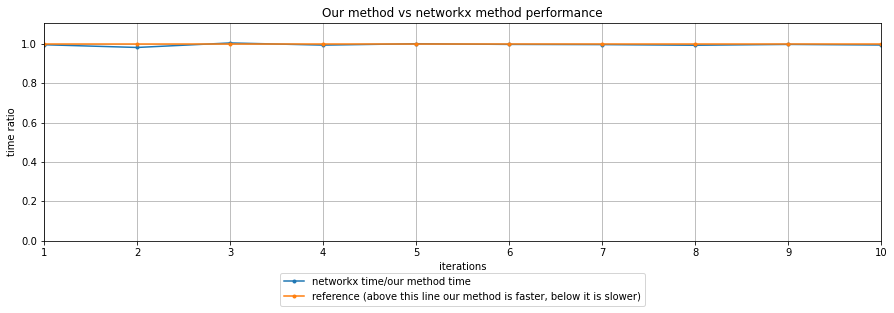

In [11]:
x=[]
ys=[]
y=[]
ref=[]

mean_community_sizes={}
for iterations in trange(1,11):
    x.append(iterations)
    with elapsed_timer() as elapsed_gn:
        communities_gn=compute_gn(G,iterations)
    
    gn_time=elapsed_gn()
    
    mean_community_size=sum([len(com) for com in communities_gn])/len(communities_gn)
    
    mean_community_sizes[iterations]=mean_community_size
    
    with elapsed_timer() as elapsed_nx:
        comp = girvan_newman(G)

        for i in range(iterations-1):
            next(comp)

        communities_nx=list(next(comp))

    nx_time=elapsed_nx()
    
    print(f'Iterations: {iterations}' )
    print(f'\tcommunities_gn == communities_nx ? (are the detected communities the same between networkx and us?) {communities_nx==communities_gn}')
    print(f'\tmean community size: {mean_community_size}')
    print(f'\tComputation time for our method: {gn_time}')
    print(f'\tComputation time for networkx method: {nx_time}')
    print(f'\tOur method is {nx_time/gn_time} times faster than networkx')
    y.append(nx_time/gn_time)
    ref.append(1)

closest_mean_com_size=min([abs(mean_social_circle_size-size) for size in mean_community_sizes.values()])         
closest_mean_com_size_iteration=0

for iterations,size in mean_community_sizes.items():
    if abs(size-mean_social_circle_size) == closest_mean_com_size:
          closest_mean_com_size_iteration=iterations
          break

print(f'The iteration that give the closest mean community size to the ground truth is {closest_mean_com_size_iteration} with a difference from ground truth of {closest_mean_com_size}')          

ys.append(y)
ys.append(ref)
plot_multi_data(x,ys,'iterations',['networkx time/our method time','reference (above this line our method is faster, below it is slower)'],'time ratio','Our method vs networkx method performance',figwidth=15)

### Find the top K users

In [21]:
GRAPH_RATIO = 1.0/100

k = int(len(G) * GRAPH_RATIO)

if k > len(G):
    print(f"Warning : K chosen : {k} is higher than the number of nodes in the graph : {len(G)}\n")

nodes_degrees = dict(G.degree())
# normalize the node degrees using the max node degree
max_deg = max(nodes_degrees.values())
nodes_degrees = {node:deg /float(max_deg) for node, deg in nodes_degrees.items()}

    
# sort the node:degree dictionary
nodes_degrees= {node: deg for node, deg in sorted(nodes_degrees.items(), key=lambda item: item[1], reverse=True)}


top_nodes = list(nodes_degrees)[:k]
top_nodes_dict = {node:nodes_degrees[node] for node in top_nodes}
print(f"{k} nodes with highest degree centrality : {top_nodes_dict}")

2 nodes with highest degree centrality : {'972651': 1.0, '813286': 0.8809523809523809}


#### Compute the ratio of presence of the top nodes in the communities

In [13]:
n_top_community_presence = 0

for community in communities_gn:
    print(community)
    if(len(set(top_nodes).intersection(community)) > 0):
        n_top_community_presence += 1

ratio_presence = n_top_community_presence / len(communities_gn)
print(f"Ratio of communities where at least one of the top nodes is present : {n_top_community_presence} / {len(communities_gn)} ({ratio_presence * 100:.1f}%)")

{'294106552', '128087229', '36999171', '231893190', '272170644', '14654965', '3936151', '90779436', '15936421', '2609891', '105643923', '156136958', '20970305', '25952851', '110315478', '236025357', '14229141', '61730210', '141861462', '214970887', '37532342', '123480187', '165411431', '296047166', '65537597', '121825928', '34068984', '15680204'}
{'168498034', '17001435', '18038892', '20050047', '19912974', '133769083', '44705716', '813286', '52528982', '46170816', '84155547', '108508328', '9624742', '88956373', '15647676', '18291500', '31639623', '20065440', '61853389', '19290585', '76945884', '14625398', '47616071', '17658786', '64954756', '19658936', '45741118', '18487054', '71012645', '314670099', '33509142', '14856951', '59062375', '16028241', '72814599', '218443914', '78941245', '17831464', '18487522', '50339952', '97008128', '8775672', '127512810', '40300027', '14503316'}
{'6385432', '7852612', '777925', '4519121', '819797', '7320972', '11222', '783214', '39445335', '9160152', '

### Find the most similar nodes

In [14]:
similarities_tested = {
    'cosine':compute_cosine_sim,
    'adamic-adar':compute_adamic_adar_sim,
}

most_similar_pairs={}

for similarity_label, similarity_func in similarities_tested.items():
    most_similar_pairs[similarity_label]=[]
    print(f'Using function : {similarity_label}')
    for top_node in top_nodes:
        top_nodes_sims = similarity_func(G, top_node)
        most_similar_pair = max(top_nodes_sims, key=top_nodes_sims.get)

        most_similar_pairs[similarity_label].append(most_similar_pair)
        print(f"\tMost similar nodes are {most_similar_pair} with similarity value : {top_nodes_sims[most_similar_pair]:.3f}") 

Using function : cosine
	Most similar nodes are ('972651', '14389031') with similarity value : 0.514
	Most similar nodes are ('813286', '88956373') with similarity value : 0.467
	Most similar nodes are ('9624742', '17658786') with similarity value : 0.834
	Most similar nodes are ('418', '696333') with similarity value : 0.859
	Most similar nodes are ('15647676', '9624742') with similarity value : 0.693
	Most similar nodes are ('17658786', '17001435') with similarity value : 0.924
	Most similar nodes are ('696333', '23543993') with similarity value : 0.962
	Most similar nodes are ('23543993', '696333') with similarity value : 0.962
	Most similar nodes are ('783214', '11222') with similarity value : 0.472
	Most similar nodes are ('7846', '767396') with similarity value : 0.556
Using function : adamic-adar
	Most similar nodes are ('972651', '14389031') with similarity value : 6.379
	Most similar nodes are ('813286', '9624742') with similarity value : 5.796
	Most similar nodes are ('962474

## Visualization

### Visualize the output of the Girvan-Newman algorithm highlighting the communities.

In [15]:
communities=compute_gn(G,closest_mean_com_size_iteration)

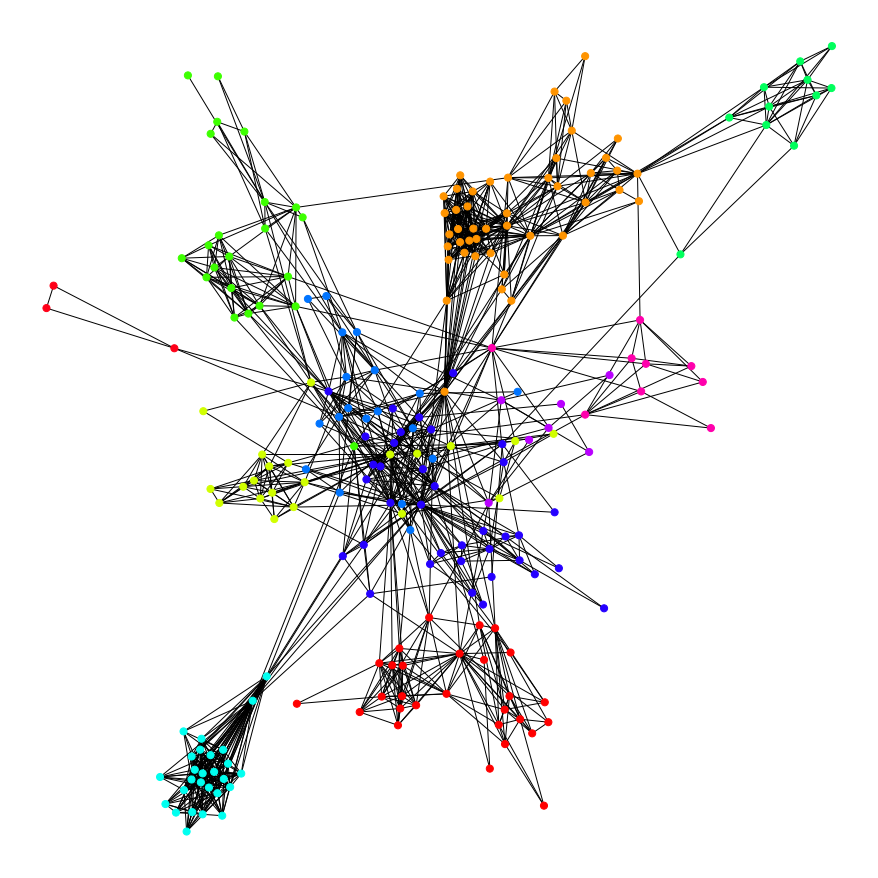

In [16]:
# hsv values range from 0.25 to 0.75
val_map = dict(zip(list(range(len(communities))),[i*0.5/len(communities)+0.25 for i in range(1,len(communities)+1)]))

node_community_dict={}

i=0
for community in communities:
    for node in community:
        node_community_dict[node]=i
    i+=1

node_colors = [val_map.get(node_community_dict[node], 0.0) for node in G.nodes()]

plt.figure(1,figsize=(12,12))
nx.draw(G,node_size=50,node_color=node_colors,cmap='hsv')
plt.show()

### Visualise the top k users identified above, highlight the pairs with highest Cosine and Adamic-Adar similarities.

Top k central users highlithed in red, most similar users according to cosine highlighted in orange:


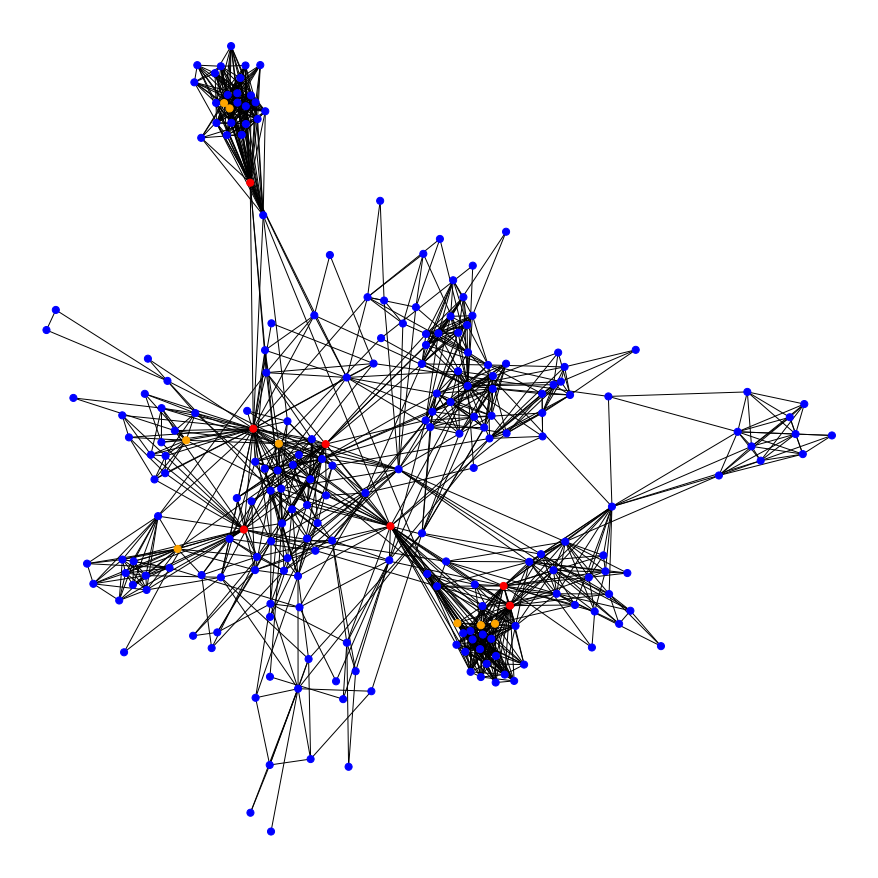

Top k central users highlithed in red, most similar users according to adamic-adar highlighted in orange:


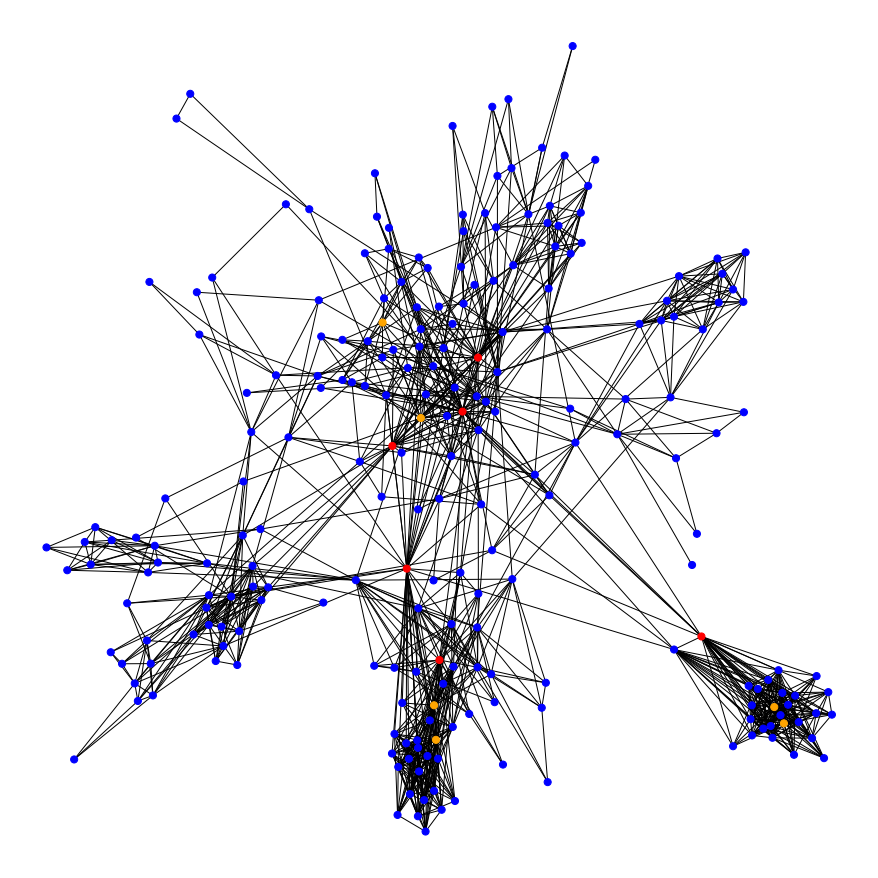

In [17]:
for sim_function, pairs in most_similar_pairs.items():
    print(f'Top k central users highlithed in red, most similar users according to {sim_function} highlighted in orange:')
    
    node_colors=[]
    
    for node in G.nodes():
        blue=True
        for pair in pairs:
            if node == pair[0]:
                node_colors.append('red')
                blue=False
                break
            if node == pair[1]:
                node_colors.append('orange')
                blue=False
                break
        if blue:
            node_colors.append('b')
    

    plt.figure(1,figsize=(12,12))
    nx.draw(G,node_size=50,node_color=node_colors)
    plt.show()